In [1]:
from threeML.io.download_from_http import ApacheDirectory
%matplotlib notebook
from jupyterthemes import jtplot
jtplot.style('oceans16', context='notebook', fscale=1)
import matplotlib.pyplot as plt




Did you try to import pygsl in the build directory?

Well, that does not work out of the box. If you want to do that, please
use
      python setup.py build_ext -i
to add the necessary extension module in the local pygsl/ directory!

Please read the README first! Any further questions or missing information
please post to pygsl-discuss@lists.sourceforge.net!


Configuration read from /Users/jburgess/.threeML/threeML_config.yml


In [14]:
main_url = 'https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/daily/'

main_apache = ApacheDirectory(main_url)

year_urls = main_apache.directories

for year in year_urls:
    
    this_year_url = "%s%s"%(main_url,year)
    
    year_apache = ApacheDirectory(this_year_url)
    
    month_urls = year_apache.directories
    
    for month in month_urls:
        
        this_month_url = "%s%s%s"%(main_url,year,month)
        
        month_apache = ApacheDirectory(this_month_url)
        
        day_urls = month_apache.directories
        
        
    
    
    


In [2]:
import astropy.io.fits as fits
from scipy.interpolate import UnivariateSpline

In [40]:
f = fits.open('glg_cspec_n4_120304_v00.pha.txt')



In [64]:
class GBMContinuousDAta(object):
    
    _valid_widths = [4.096,1.024,]
    
    def __init__(self,filename):
        
        
        
        with fits.open(filename) as f:
            
            spec_ext = f['SPECTRUM']
            
            self._exposure = spec_ext.data['EXPOSURE']
            self._start_times = spec_ext.data['TIME']
            self._stop_times = spec_ext.data['ENDTIME']
            self._counts = spec_ext.data['COUNTS']
            
        
        self._total_counts = self._counts.sum(axis=1)
        self._widths = self._stop_times - self._start_times
        
        self._means = np.mean(zip(self._start_times,self._stop_times),axis=1)
        
        self._break_up_intervals()
        self._filter_burst_intervals()
        
        self._fit_all_intervals()
        
        self._extract_good()
        self._create_spectra()
        #self._interpolate_good_intervals()
        
    def _break_up_intervals(self):
        
        non_zero_mask = self._total_counts > 0
        
        np.allclose
        
        
        self._intervals = slice_disjoint(non_zero_mask.nonzero()[0])
        
        self._n_intervals = len(self._intervals)
        
        
    def _filter_burst_intervals(self):
        
        self._drop_idx = []
        
        for i, (start,stop) in enumerate(self._intervals):
            
            this_selection = self._widths[start:stop]
            
            if not np.allclose(this_selection,4.096,atol=1E-3):
                
                self._drop_idx.append(i)
    
    
    def _fit_all_intervals(self):
        self._polys = []
        self._poly_start = []
        self._poly_stop =[]
        self._good = []
        self._zero_time = []
        
        
        for i, (start,stop) in enumerate(self._intervals):
            
            if i not in self._drop_idx:
                
                self._poly_fit_interval(i)
        
        
        
                
    def _poly_fit_interval(self,interval_number):
        
        start, stop = self._intervals[interval_number]
        
        step = 150
        
        
        ii = start
        while (ii<=stop):
            
            if ii+step<=stop:
            
                xs = self._means[ii:ii+step]
                
                zero_time = np.median(xs)
                
                tt =xs-zero_time
                
                
                ys = self._total_counts[ii:ii+step]
                es = self._exposure[ii:ii+step]
                
                min_grade = 0
                max_grade = 5
                log_likelihoods = []

                for grade in range(min_grade, max_grade + 1):
                    polynomial, log_like = polyfit(tt,ys,grade,exposure=es)

                    log_likelihoods.append(log_like)

                # Found the best one
                delta_loglike = np.array(map(lambda x: 2 * (x[0] - x[1]), zip(log_likelihoods[:-1], log_likelihoods[1:])))

                delta_threshold = 9.0

                mask = (delta_loglike >= delta_threshold)

                if (len(mask.nonzero()[0]) == 0):

                    # best grade is zero!
                    best_grade = 0

                else:

                    best_grade = mask.nonzero()[0][-1] + 1

            



                poly, mll = polyfit(tt,ys,best_grade,exposure=es)
                self._polys.append(poly)
                self._poly_start.append(ii)
                self._poly_stop.append(ii+step)
                self._zero_time.append(zero_time)
                
                # now get the sigs:
                
                sigma_bs = []
                estimated = []
                
                for tstart,tstop in zip(self._start_times[ii:ii+step]-zero_time,self._stop_times[ii:ii+step]-zero_time):
                    
                    sigma_bs.append(poly.integral_error(tstart,tstop))
                    estimated.append(poly.integral(tstart,tstop))
                    
                    
                sig = Significance(self._total_counts[ii:ii+step],np.array(estimated))
                all_sig = sig.li_and_ma_equivalent_for_gaussian_background(np.array(sigma_bs))
                
                
                if np.any(np.abs(all_sig)>5):
                    
                    self._good.append(False)
                else:
                    
                    self._good.append(True)
                    
                
                #print(np.min(all_sig),np.max(all_sig))
                
                
                
                

            ii+=step
            
        
        
        
        
        
    
    
    def _interpolate_good_intervals(self):
        
        
        self._splines = []
        
        for i, (start,stop) in enumerate(self._intervals):
            
            if i not in self._drop_idx:
                
                xs = self._means[start:stop]
                ys = self._total_counts[start:stop]/self._exposure[start:stop]
                
                this_spline = UnivariateSpline(xs,ys,s=240)
                #this_spline.set_smoothing_factor(0.5)
                
                self._splines.append(this_spline)
                
                
            
    
    
    
    
    def plot_all(self,show_bad=False,show_spline=False):
        
        
        fig, ax = plt.subplots()
        
        if show_bad:
        
            for i in xrange(self._n_intervals):

                if i in self._drop_idx:

                    color='r'

                else:

                    color='g'

                self._plot_interval(i,ax,color=color)
                
        else:
            
            itr = 0
            for i, (start,stop) in enumerate(self._intervals):
                
                if i not in self._drop_idx:
                    
                    self._plot_interval(i,ax)
        
                    
                        
                    itr+=1
                    
        if show_spline:
            
            for p,s,e,g,zt in zip(self._polys,self._poly_start,self._poly_stop,self._good,self._zero_time):
                
                

                time = self._means[s:e]
                
                bkg = []
                
                
                
                for ii,jj,kk in zip(self._start_times[s:e]-zt,
                                    self._stop_times[s:e]-zt,
                                    self._exposure[s:e]):
                    
                    
                    
                    bkg.append(p.integral(ii,jj)/kk)
                
                
                if g:
                    
                    color ='w'
                    
                else:
                    
                    color = 'grey'
                
                
                
                ax.plot(time,bkg,color=color)
                
                
    def _extract_good(self,with_bkg=False):
        
        self._good_bkgs = []
        self._good_intervals = []
        
            
        for p,s,e,g,zt in zip(self._polys,self._poly_start,self._poly_stop,self._good,self._zero_time):
            if g:

                
                
                if with_bkg:
                    time = self._means[s:e]

                    bkg = []



                    for ii,jj,kk in zip(self._start_times[s:e]-zt,
                                        self._stop_times[s:e]-zt,
                                        self._exposure[s:e]):



                        bkg.append(p.integral(ii,jj)/kk)
                    
                    self._good_bkgs.append(bkg)
                
                self._good_intervals.append([s,e])


                
                
    def _create_spectra(self):
        
        self._spectra = []
        self._total_exposure = []
        
        step = 5
        
    
        
        for i, (start,stop) in enumerate(self._good_intervals):
            
            
            
            for j in xrange(start,stop,step):
                spectrum = np.zeros(self._counts.shape[1])
                exposure = 0.
                
                
                if j+step<=stop:
                
                
                    for k in range(step):
                        
                        exposure += self._exposure[j+k]
                        spectrum += self._counts[j+k,:]
                
                
                
                    self._spectra.append(spectrum)
                    self._total_exposure.append(exposure)
         
        

    def plot_good(self):
        
        fig,ax = plt.subplots()
        
        for bkg, (start,stop) in zip(self._good_bkgs,self._good_intervals):
            
            time = self._means[start:stop]
            
            self._hist_slice(start,stop,ax,color='b')
            
            ax.plot(time,bkg,color='w',lw=0.8)
            
            
 

    def _hist_slice(self,start,stop,ax,**kwargs):
        
        bins = zip(self._start_times[start:stop], self._stop_times[start:stop])
        counts = self._total_counts[start:stop]
        exposure = self._exposure[start:stop]
        
        
        step_plot(xbins=bins,y=counts/exposure,ax=ax,**kwargs)
        
        
    
    
    def _plot_interval(self,interval_number,ax,**kwargs):
        
        
        start, stop = self._intervals[interval_number]
        
        self._hist_slice(start,stop,ax,**kwargs)
        
 
        
        
        



            
            
        
        

In [65]:
tt = GBMContinuousDAta('glg_cspec_n8_120318_v00.pha.txt')


WARNING RuntimeWarning: invalid value encountered in sqrt


WARNING RuntimeWarning: invalid value encountered in sqrt


WARNING RuntimeWarning: invalid value encountered in sqrt


WARNING RuntimeWarning: invalid value encountered in sqrt


WARNING RuntimeWarning: invalid value encountered in sqrt


WARNING RuntimeWarning: invalid value encountered in sqrt


WARNING RuntimeWarning: invalid value encountered in sqrt


WARNING RuntimeWarning: invalid value encountered in sqrt


WARNING RuntimeWarning: invalid value encountered in sqrt


WARNING RuntimeWarning: invalid value encountered in sqrt


WARNING RuntimeWarning: invalid value encountered in sqrt


WARNING RuntimeWarning: invalid value encountered in sqrt


WARNING RuntimeWarning: invalid value encountered in sqrt


WARNING RuntimeWarning: invalid value encountered in sqrt


WARNING RuntimeWarning: invalid value encountered in sqrt


WARNING RuntimeWarning: invalid value encountered in sqrt


WARNING RuntimeWarning: invalid value e

<IPython.core.display.Javascript object>


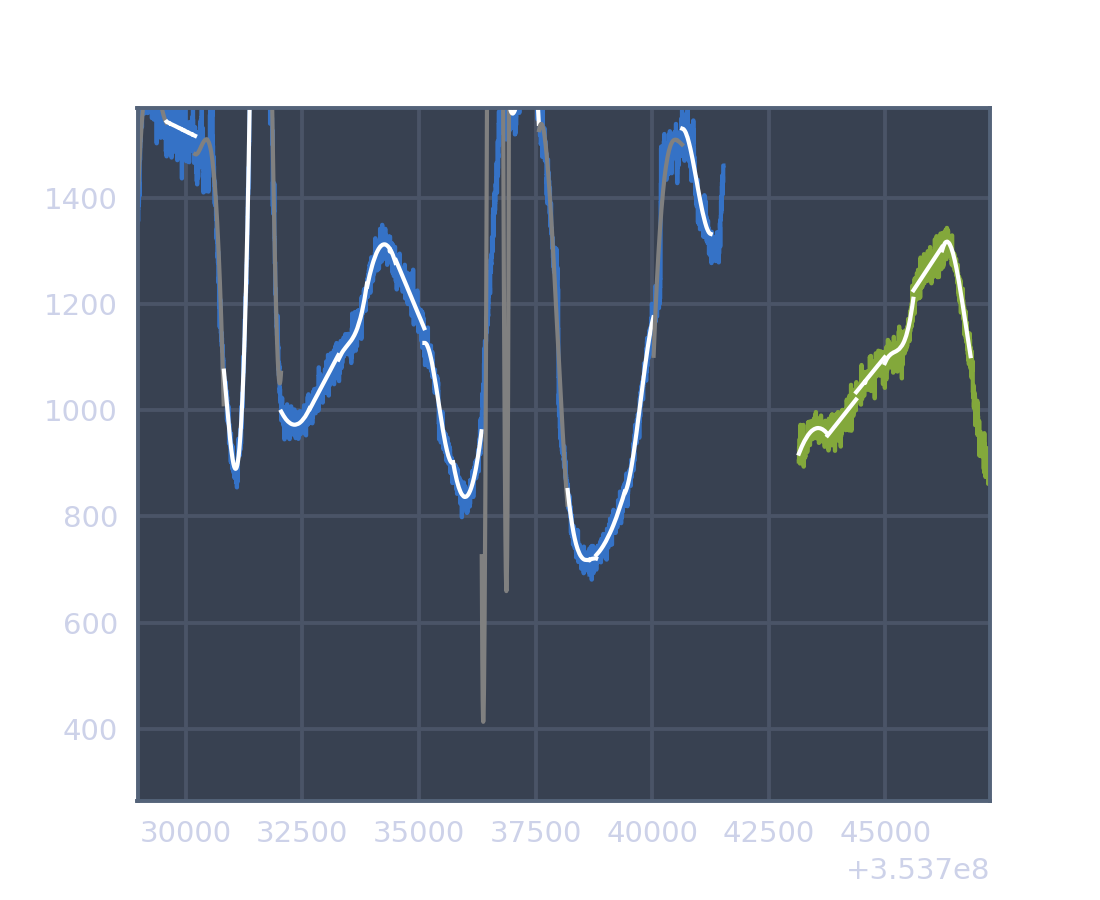

In [44]:
tt.plot_all(show_bad=False,show_spline=True)

<IPython.core.display.Javascript object>


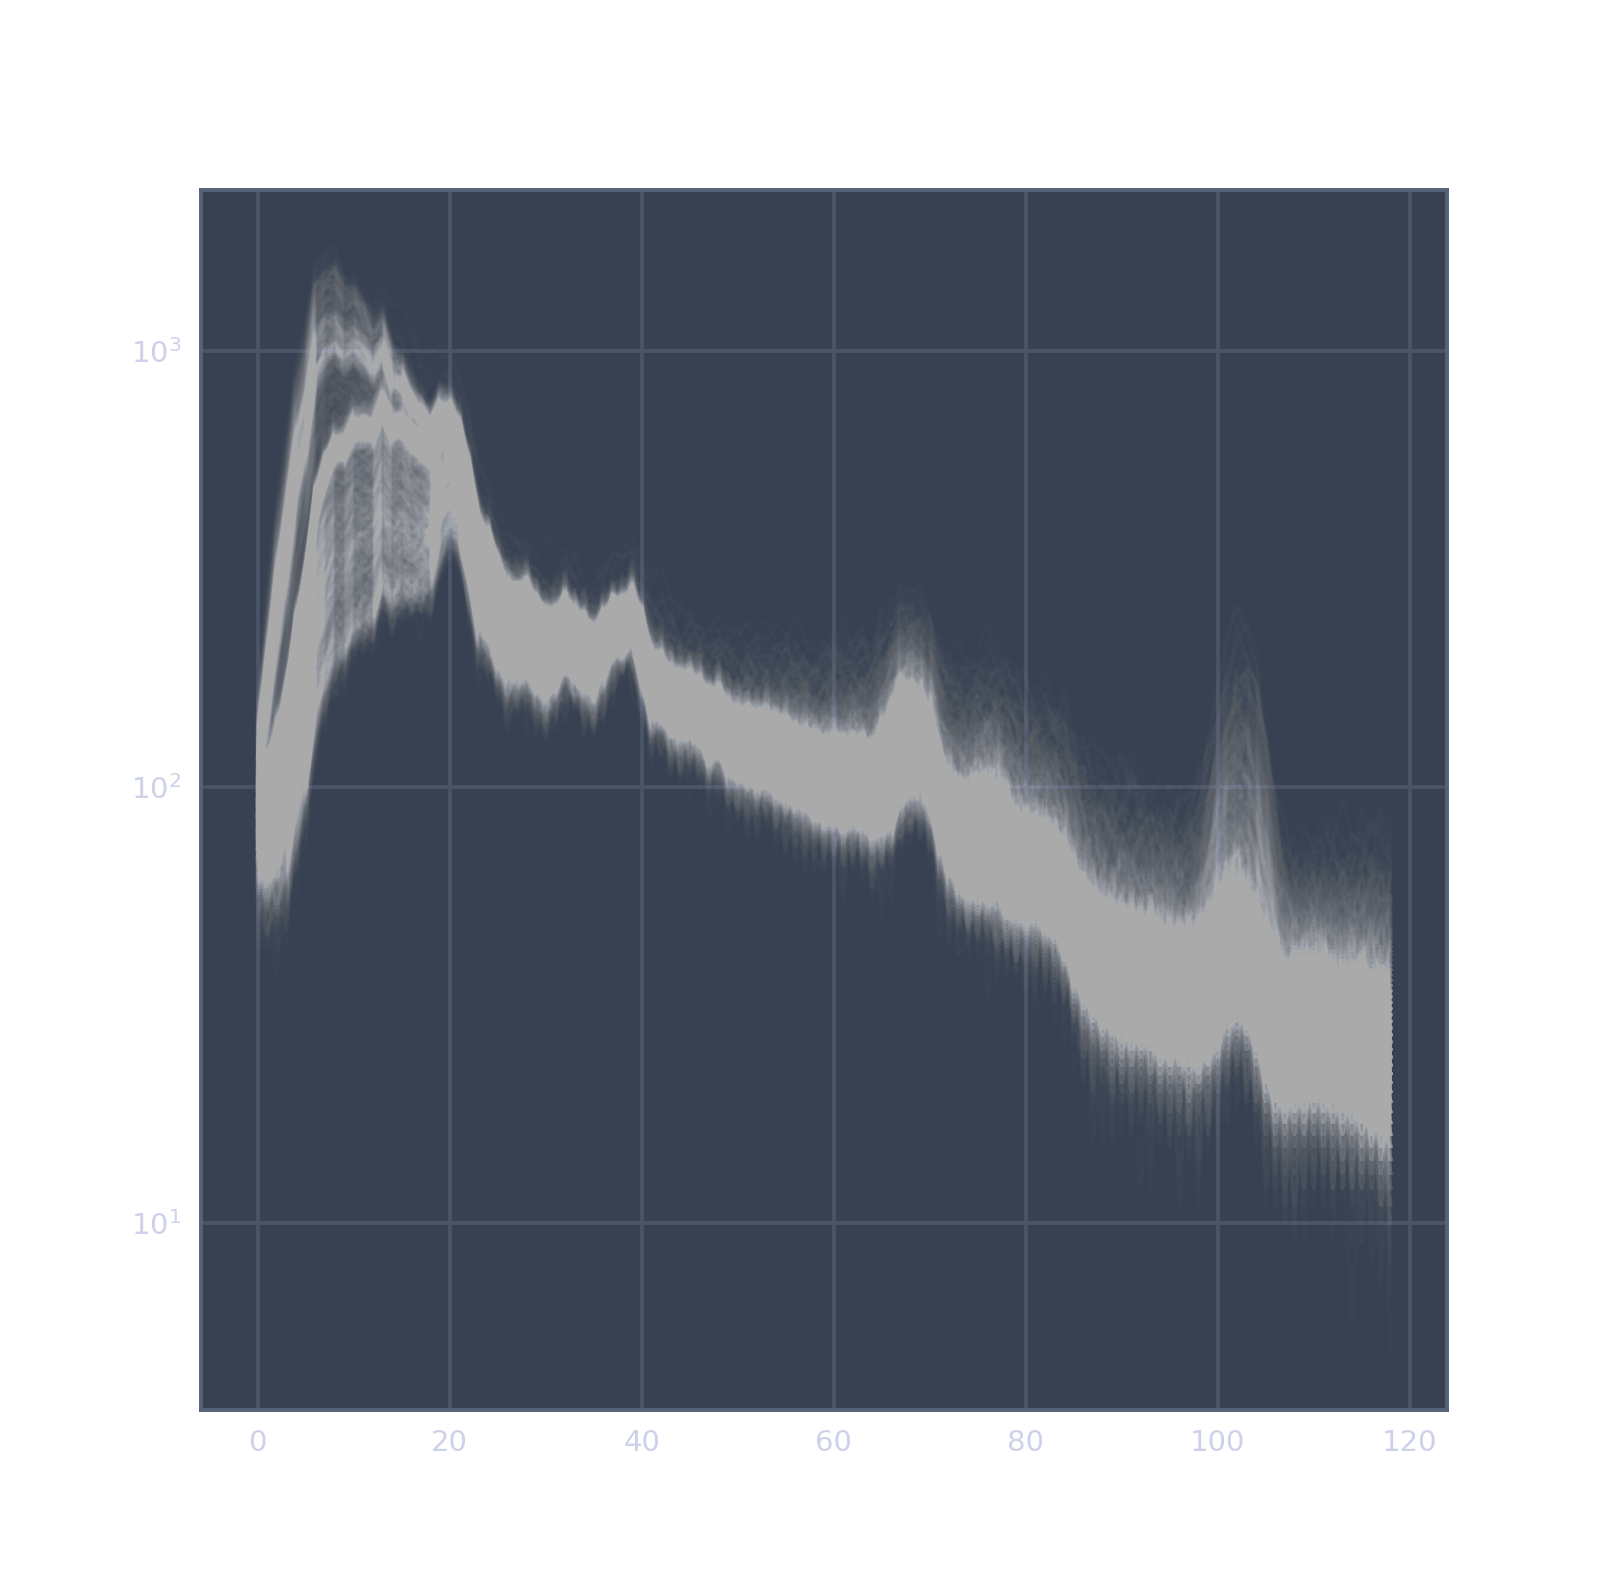

In [72]:
fig, ax = plt.subplots()

for spec in tt._spectra:
    
    
    ax.semilogy(spec[1:120],alpha=0.01,color='w')


In [60]:
tt._good_intervals

[[0, 150],
 [150, 300],
 [300, 450],
 [450, 600],
 [600, 750],
 [750, 900],
 [900, 1050],
 [1350, 1500],
 [1500, 1650],
 [1950, 2100],
 [2250, 2400],
 [2550, 2700],
 [2700, 2850],
 [2850, 3000],
 [3000, 3150],
 [3150, 3300],
 [3300, 3450],
 [3450, 3600],
 [3750, 3900],
 [4050, 4200],
 [4200, 4350],
 [4350, 4500],
 [4650, 4800],
 [5495, 5645],
 [5645, 5795],
 [5795, 5945],
 [5945, 6095],
 [6095, 6245],
 [6245, 6395],
 [6811, 6961],
 [6961, 7111],
 [7261, 7411],
 [7411, 7561],
 [7753, 7903],
 [7903, 8053],
 [8053, 8203],
 [8203, 8353],
 [8353, 8503],
 [8503, 8653],
 [8660, 8810],
 [8810, 8960],
 [8960, 9110],
 [9110, 9260],
 [9260, 9410],
 [9410, 9560],
 [9560, 9710],
 [9883, 10033],
 [10033, 10183],
 [10183, 10333],
 [10333, 10483],
 [10483, 10633],
 [10633, 10783],
 [10860, 11010],
 [11010, 11160],
 [11160, 11310],
 [11460, 11610],
 [11610, 11760],
 [11760, 11910],
 [12027, 12177],
 [12177, 12327],
 [12327, 12477],
 [12477, 12627],
 [12627, 12777],
 [12777, 12927],
 [12927, 13077],
 [1

In [23]:
tt._poly_start[0]

0

In [24]:
tt._poly_stop[0]

250

In [28]:
p.integral(tt._start_times[2],tt._stop_times[2])

-1048576.0

In [29]:
tt._start_times[0]

353721597.50507802

In [ ]:
tt._start_times[0]

In [4]:
import numpy as np
class Polynomial(object):
    def __init__(self, coefficients, is_integral=False):

        """

        :param coefficients: array of poly coefficients
        :param is_integral: if this polynomial is an
        """
        self._coefficients = coefficients
        self._degree = len(coefficients) - 1

        self._i_plus_1 = np.array(range(1, self._degree + 1 + 1), dtype=float)

        self._cov_matrix = np.zeros((self._degree + 1, self._degree + 1))

        # we can fix some things for speed
        # we only need to set the coeff for the
        # integral polynomial
        if not is_integral:

            integral_coeff = [0]

            integral_coeff.extend(map(lambda i: self._coefficients[i - 1] / float(i), range(1, self._degree + 1 + 1)))

            self._integral_polynomial = Polynomial(integral_coeff, is_integral=True)

 
    @property
    def degree(self):
        """
        the polynomial degree
        :return:
        """
        return self._degree

    @property
    def error(self):
        """
        the error on the polynomial coefficients
        :return:
        """
        return np.sqrt(self._cov_matrix.diagonal())

    def __get_coefficient(self):
        """ gets the coefficients"""

        return self._coefficients

    def ___get_coefficient(self):
        """ Indirect coefficient getter """

        return self.__get_coefficient()

    def __set_coefficient(self, val):
        """ sets the coefficients"""

        self._coefficients = val

        integral_coeff = [0]

        integral_coeff.extend(map(lambda i: self._coefficients[i - 1] / float(i), range(1, self._degree + 1 + 1)))

        self._integral_polynomial = Polynomial(integral_coeff, is_integral=True)

    def ___set_coefficient(self, val):
        """ Indirect coefficient setter """

        return self.__set_coefficient(val)

    coefficients = property(___get_coefficient, ___set_coefficient,
                            doc="""Gets or sets the coefficients of the polynomial.""")

    def __call__(self, x):

        result = 0
        for coefficient in self._coefficients[::-1]:
            result = result * x + coefficient
        return result

    def compute_covariance_matrix(self, function, best_fit_parameters):
        """
        Compute the covariance matrix of this fit
        :param function: the loglike for the fit
        :param best_fit_parameters: the best fit parameters
        :return:
        """

        minima = np.zeros_like(best_fit_parameters) - 100
        maxima = np.zeros_like(best_fit_parameters) + 100

        try:

            hessian_matrix = get_hessian(function, best_fit_parameters, minima, maxima)

        except ParameterOnBoundary:

            custom_warnings.warn("One or more of the parameters are at their boundaries. Cannot compute covariance and"
                                 " errors", CannotComputeCovariance)

            n_dim = len(best_fit_parameters)

            self._cov_matrix = np.zeros((n_dim, n_dim)) * np.nan

        # Invert it to get the covariance matrix

        try:

            covariance_matrix = np.linalg.inv(hessian_matrix)

            self._cov_matrix = covariance_matrix



        except:

            custom_warnings.warn("Cannot invert Hessian matrix, looks like the matrix is singluar")

            n_dim = len(best_fit_parameters)

            self._cov_matrix = np.zeros((n_dim, n_dim)) * np.nan

    @property
    def covariance_matrix(self):
        return self._cov_matrix

    def integral(self, xmin, xmax):
        """ 
        Evaluate the integral of the polynomial between xmin and xmax

        """

        return self._integral_polynomial(xmax) - self._integral_polynomial(xmin)

    def _eval_basis(self, x):

        return (1. / self._i_plus_1) * np.power(x, self._i_plus_1)

    def integral_error(self, xmin, xmax):
        """
        computes the integral error of an interval
        :param xmin: start of the interval
        :param xmax: stop of the interval
        :return: interval error
        """
        c = self._eval_basis(xmax) - self._eval_basis(xmin)
        tmp = c.dot(self._cov_matrix)
        err2 = tmp.dot(c)

        return np.sqrt(err2)

class PolyLogLikelihood(object):
    """
    Implements a Poisson likelihood (i.e., the Cash statistic). Mind that this is not
    the Castor statistic (Cstat). The difference between the two is a constant given
    a dataset. I kept Cash instead of Castor to make easier the comparison with ROOT
    during tests, since ROOT implements the Cash statistic.
    """

    def __init__(self, x, y, model, exposure):
        self._bin_centers = x
        self._counts = y
        self._model = model
        self._parameters = model.coefficients
        self._exposure = exposure

        def cov_call(*parameters):
            self._model.coefficients = parameters
            M = self._model(self._bin_centers) * self._exposure
            M_fixed, tiny = self._fix_precision(M)

            # Replace negative values for the model (impossible in the Poisson context)
            # with zero

            negative_mask = (M < 0)
            if (len(negative_mask.nonzero()[0]) > 0):
                M[negative_mask] = 0.0

            # Poisson loglikelihood statistic (Cash) is:
            # L = Sum ( M_i - D_i * log(M_i))

            logM = self._evaluate_logM(M)

            # Evaluate v_i = D_i * log(M_i): if D_i = 0 then the product is zero
            # whatever value has log(M_i). Thus, initialize the whole vector v = {v_i}
            # to zero, then overwrite the elements corresponding to D_i > 0

            d_times_logM = np.zeros(len(self._counts))

            non_zero_mask = (self._counts > 0)

            d_times_logM[non_zero_mask] = self._counts[non_zero_mask] * logM[non_zero_mask]

            log_likelihood = np.sum(M_fixed - d_times_logM)

            return log_likelihood

        self.cov_call = cov_call

    def _evaluate_logM(self, M):
        # Evaluate the logarithm with protection for negative or small
        # numbers, using a smooth linear extrapolation (better than just a sharp
        # cutoff)
        tiny = np.float64(np.finfo(M[0]).tiny)

        non_tiny_mask = (M > 2.0 * tiny)

        tink_mask = np.logical_not(non_tiny_mask)

        if (len(tink_mask.nonzero()[0]) > 0):
            logM = np.zeros(len(M))
            logM[tink_mask] = np.abs(M[tink_mask]) / tiny + np.log(tiny) - 1
            logM[non_tiny_mask] = np.log(M[non_tiny_mask])

        else:

            logM = np.log(M)

        return logM

    def __call__(self, parameters):
        """
          Evaluate the Cash statistic for the given set of parameters
        """

        # Compute the values for the model given this set of parameters
        # model is in counts

        self._model.coefficients = parameters
        M = self._model(self._bin_centers) * self._exposure
        M_fixed, tiny = self._fix_precision(M)

        # Replace negative values for the model (impossible in the Poisson context)
        # with zero

        negative_mask = (M < 0)
        if (len(negative_mask.nonzero()[0]) > 0):
            M[negative_mask] = 0.0

        # Poisson loglikelihood statistic (Cash) is:
        # L = Sum ( M_i - D_i * log(M_i))

        logM = self._evaluate_logM(M)

        # Evaluate v_i = D_i * log(M_i): if D_i = 0 then the product is zero
        # whatever value has log(M_i). Thus, initialize the whole vector v = {v_i}
        # to zero, then overwrite the elements corresponding to D_i > 0

        d_times_logM = np.zeros(len(self._counts))

        non_zero_mask = (self._counts > 0)

        d_times_logM[non_zero_mask] = self._counts[non_zero_mask] * logM[non_zero_mask]

        log_likelihood = np.sum(M_fixed - d_times_logM)

        return log_likelihood

    def _fix_precision(self, v):
        """
          Round extremely small number inside v to the smallest usable
          number of the type corresponding to v. This is to avoid warnings
          and errors like underflows or overflows in math operations.
        """
        tiny = np.float64(np.finfo(v[0]).tiny)
        zero_mask = (np.abs(v) <= tiny)
        if (len(zero_mask.nonzero()[0]) > 0):
            v[zero_mask] = np.sign(v[zero_mask]) * tiny

        return v, tiny


def polyfit(x, y, grade, exposure):
    """ function to fit a polynomial to event data. not a member to allow parallel computation """

    # Check that we have enough counts to perform the fit, otherwise
    # return a "zero polynomial"
    non_zero_mask = (y > 0)
    n_non_zero = len(non_zero_mask.nonzero()[0])
    if n_non_zero == 0:
        # No data, nothing to do!
        return Polynomial([0.0]), 0.0

    # Compute an initial guess for the polynomial parameters,
    # with a least-square fit (with weight=1) using SVD (extremely robust):
    # (note that polyfit returns the coefficient starting from the maximum grade,
    # thus we need to reverse the order)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        initial_guess = np.polyfit(x, y, grade)

    initial_guess = initial_guess[::-1]

    polynomial = Polynomial(initial_guess)

    # Check that the solution found is meaningful (i.e., definite positive
    # in the interval of interest)
    M = polynomial(x)

    negative_mask = (M < 0)

    if len(negative_mask.nonzero()[0]) > 0:
        # Least square fit failed to converge to a meaningful solution
        # Reset the initialGuess to reasonable value
        initial_guess[0] = np.mean(y)
        meanx = np.mean(x)
        initial_guess = map(lambda x: abs(x[1]) / pow(meanx, x[0]), enumerate(initial_guess))

    # Improve the solution using a logLikelihood statistic (Cash statistic)
    log_likelihood = PolyLogLikelihood(x, y, polynomial, exposure)

    # Check that we have enough non-empty bins to fit this grade of polynomial,
    # otherwise lower the grade
    dof = n_non_zero - (grade + 1)

    if dof <= 2:
        # Fit is poorly or ill-conditioned, have to reduce the number of parameters
        while (dof < 2 and len(initial_guess) > 1):
            initial_guess = initial_guess[:-1]
            polynomial = Polynomial(initial_guess)
            log_likelihood = PolyLogLikelihood(x, y, polynomial, exposure)

    # Try to improve the fit with the log-likelihood



    final_estimate = \
    opt.minimize(log_likelihood, initial_guess)['x']
    final_estimate = np.atleast_1d(final_estimate)

    # Get the value for cstat at the minimum

    min_log_likelihood = log_likelihood(final_estimate)

    # Update the polynomial with the fitted parameters,
    # and the relative covariance matrix

    final_polynomial = Polynomial(final_estimate)

    final_polynomial.compute_covariance_matrix(log_likelihood.cov_call, final_estimate)


    return final_polynomial, min_log_likelihood


In [5]:
import warnings
import scipy.optimize as opt

In [6]:
def slice_disjoint(arr):

    slices = []
    start_slice = arr[0]
    counter = 0
    
    for i in range(len(arr) - 1):
        if arr[i + 1] > (arr[i] + 1):
            end_slice = arr[i]
            slices.append([start_slice, end_slice])
            start_slice = arr[i + 1]
            counter += 1
    if counter == 0:
        return [[arr[0], arr[-1]]]
    if end_slice != arr[-1]:
        slices.append([start_slice, arr[-1]])
    return slices




def step_plot(xbins, y, ax, fill=False, fill_min=0, **kwargs):
    if fill:

        x = []
        newy = []

        for (start,stop), v in zip(xbins, y):
            x.append(start)
            newy.append(v)
            x.append(stop)
            newy.append(v)

        ax.fill_between(x, newy, fill_min, **kwargs)

    else:

        # This supports a mask, so the line will not be drawn for missing bins

        new_x = []
        new_y = []

        for (x1, x2), y in zip(xbins, y):

            if len(new_x) == 0:

                # First iteration

                new_x.append(x1)
                new_x.append(x2)
                new_y.append(y)

            else:

                if x1 == new_x[-1]:

                    # This bin is contiguous to the previous one

                    new_x.append(x2)
                    new_y.append(y)

                else:

                    # This bin is not contiguous to the previous one
                    # Add a "missing bin"
                    new_x.append(x1)
                    new_y.append(np.nan)
                    new_x.append(x2)
                    new_y.append(y)

        new_y.append(new_y[-1])

        new_y = np.ma.masked_where(~np.isfinite(new_y), new_y)

        ax.step(new_x, new_y, where='post',**kwargs)


In [7]:
from threeML.utils.differentiation import get_hessian, ParameterOnBoundary

In [8]:
class Significance(object):
    """
    Implements equations in Li&Ma 1983

    """

    def __init__(self, Non, Noff, alpha=1):

        assert alpha > 0 and alpha <= 1,  'alpha was %f' %alpha

        self.Non = np.array(Non, dtype=float, ndmin=1)

        self.Noff = np.array(Noff, dtype=float, ndmin=1)

        self.alpha = float(alpha)

        self.expected = self.alpha * self.Noff

        self.net = self.Non - self.expected

   
 
    def li_and_ma_equivalent_for_gaussian_background(self, sigma_b):

        # This is a computation I need to publish (G. Vianello)

        b = self.expected
        o = self.Non

        b0 = 0.5 * (np.sqrt(b ** 2 - 2 * sigma_b ** 2 * (b - 2 * o) + sigma_b ** 4) + b - sigma_b ** 2)

        S = np.sqrt(2) * np.sqrt(o * np.log(o / b0) + (b0 - b) ** 2 / (2 * sigma_b ** 2) + b0 - o)

        sign = np.where(o > b, 1, -1)

        return sign * S
